In [1]:
from xgboost import XGBClassifier
import warnings
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from tabpfn_new.scripts.transformer_prediction_interface import TabPFNClassifier, MedPFNClassifier
from tabpfn_new.scripts.model_builder import load_model
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from data_prep_utils import *
from evaluate import *
#from load_models import *
import matplotlib.pyplot as plt
import math
import torch
import openml
import time
import matplotlib as mpl
#pd.set_option('display.expand_frame_repr', False)

In [7]:
path = "datasets/data_all.csv"
all_data, labels = get_microbiome(path)
all_data = remove_zero_features(all_data)
all_data, labels = unison_shuffled_copies(all_data, labels, seed=42)

In [3]:
print(np.max(all_data))

1.0


In [9]:

reducer = AnovaSelect()
reducer.fit(all_data,labels)
scores = reducer.anova.scores_
reducer2 = AnovaSelect()
p = np.random.permutation(all_data.shape[1])
p_rev = np.argsort(p)
reducer2.fit(all_data[:,p],labels)
data1 = reducer.transform(all_data)
data2 = reducer2.transform(all_data[:,p])
print(np.max(data1), np.max(data2))

0.9775588977558897 0.9775588977558897


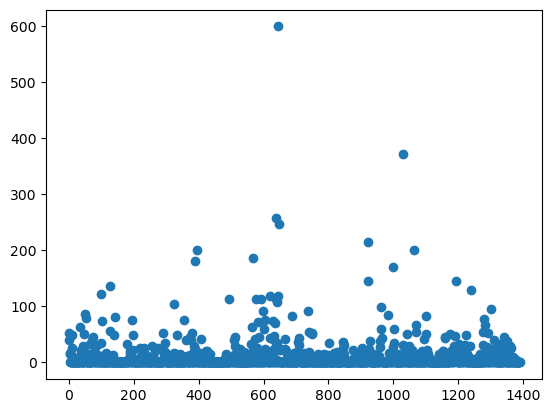

62


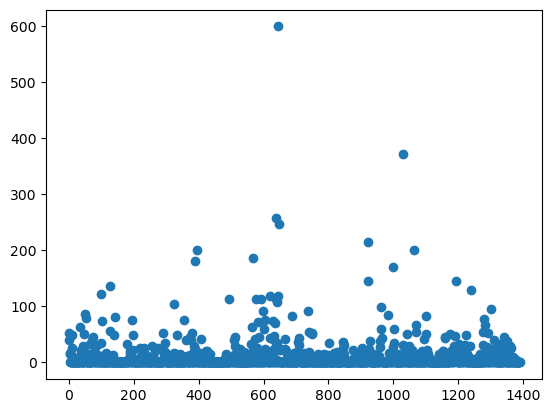

In [11]:
scores = reducer.anova.scores_
#_ = plt.hist(scores,100)
plt.scatter(np.arange(scores.shape[0]), scores)
plt.show()
scores2 = reducer2.anova.scores_
#_ = plt.hist(scores2[scores2>10],100)
plt.scatter(np.arange(scores2.shape[0]), scores2[p_rev])
print(np.sum(1*(scores>50)))

In [22]:
def small_eval(model, X_train, y_train, X_test, y_test):
    results = np.empty(2)
    with torch.no_grad():
        model.fit(X_train, y_train, overwrite_warning=True)
        probs = model.predict_proba(X_test)
        preds = np.argmax(probs, axis=1)
        y_test_1hot = torch.nn.functional.one_hot(torch.tensor(y_test).to(torch.int64)).numpy()
        results[0] = (sklearn.metrics.get_scorer("roc_auc")._score_func(y_test_1hot, probs, multi_class="ovr"))
        results[1] = (sklearn.metrics.get_scorer("f1")._score_func(y_test, preds))
    return results

### Feature importance - Leave-one-covariate-out (LOCO)

In [61]:
save = True
sampling = None
cv = 3
best_delete = 0
strat_split = True
max_samples = 1024
no_pre_process = "none"
multi_decoder = "permutation"
N_ens = 1
seed = 42
overwrite = True
metrics = ["roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "small_mlp_var_balance_05weight_anova_bestwithnoisebnn_100"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"

model = MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process)
#model = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic')


reducer = AnovaSelect()




size = min(labels.shape[0],np.floor(max_samples*(cv/(cv-1))))
runs = int(all_data.shape[0]//size)
data_sections, label_sections = stratified_split(all_data, labels,cv=runs)


rocs = []
f1s = []

fs = [44,1240,1000,1031,257,637, 1063]
fs = np.arange(0,1391,1)
for f in fs:# range(0,3):#(750,1391):
    if f%100==0:
        print("Currently at feature: ", f)
    results_all = np.zeros(2)
    loco_results_all = np.zeros(2)
    for r in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(data_sections[r], label_sections[r], test_size=0.2, stratify=label_sections[r], random_state=42)
        
        X_train[:,[0,f]] = X_train[:,[f,0]]
        X_test[:,[0,f]] = X_test[:,[f,0]]
        
        X_train, X_test = remove_same_features_traintest(X_train, X_test)
        reducer.fit(X_train, y_train)
        if (reducer.feature_indices==0).nonzero()[0]>=100:
            np.insert(reducer.feature_indices, 0, 0)
        
        X_train, X_test = reducer.transform(X_train), reducer.transform(X_test)
        
        results_all += small_eval(model, X_train, y_train, X_test,y_test)
        
        # remove feature
        med = np.mean(np.concatenate((X_train[:,0],X_test[:,0]),axis=0))
        X_train[:,0] = med
        X_test[:,0] = med
        
        loco_results_all += small_eval(model, X_train, y_train, X_test,y_test)
    loco_results = loco_results_all/runs
    results= results_all/runs
    #print(results, loco_results)
    #print(results, loco_results)
    #model.pred_model.model[2].zero_grad()
    rocs.append(results[0]-loco_results[0])
    f1s.append(results[1]-loco_results[1])
rocs = np.array(rocs)
f1s = np.array(f1s)
red_name ="fi-loco"
directory = f"results/{red_name}"
if not os.path.exists(directory):
    os.makedirs(directory)
if save:
    np.save(f"results/{red_name}/extranew_rocs1.npy", rocs)
    np.save(f"results/{red_name}/extranew_f1s1.npy", f1s)

Currently at feature:  0
Currently at feature:  100
Currently at feature:  200
Currently at feature:  300
Currently at feature:  400
Currently at feature:  500
Currently at feature:  600
Currently at feature:  700
Currently at feature:  800
Currently at feature:  900
Currently at feature:  1000
Currently at feature:  1100
Currently at feature:  1200
Currently at feature:  1300


-0.015630797773654836


C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\lenna\AppData\Local\Temp\ipykernel_20996\2463977174.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("RdBu").copy()


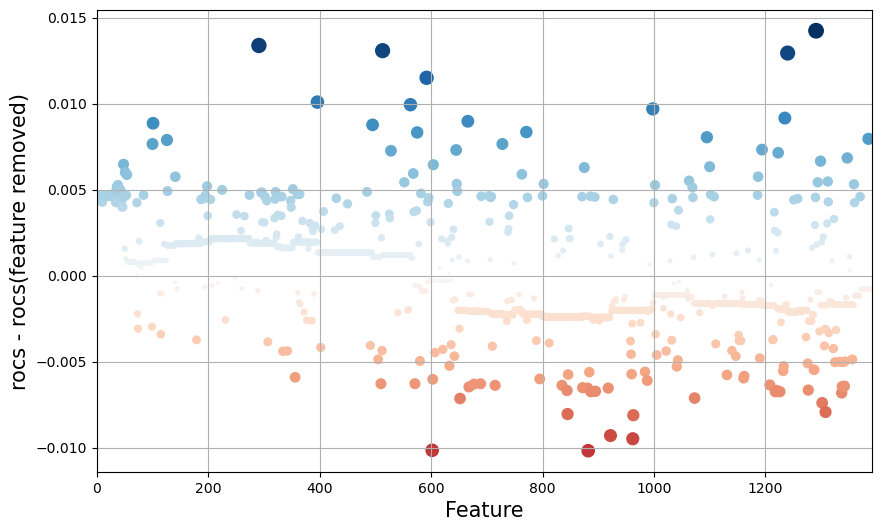

-0.019446004092956548


<Figure size 640x480 with 0 Axes>

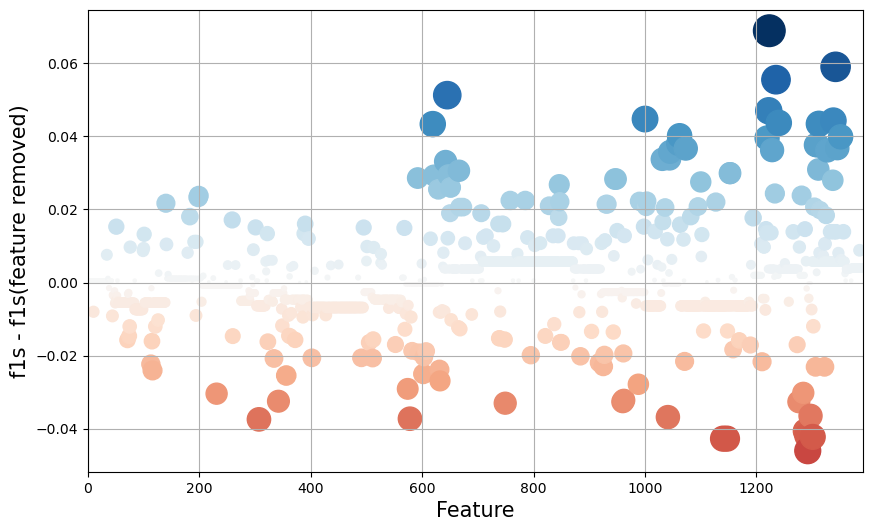

<Figure size 640x480 with 0 Axes>

In [22]:
for m in ["rocs", "f1s"]:
    red_name ="fi-loco"
    file1 = np.load(f"results/{red_name}/extranew_{m}1.npy")
    #file2 = np.load(f"results/{red_name}/extranew_{m}2.npy")
    full = file1#np.concatenate((file1, file2), axis=0)
    full = np.ma.masked_where(full==0,full)
    print(np.median(full))
    plt.figure(figsize=(10,6), dpi=100)
    #plt.hist(full, bins=100)
    cmap = mpl.cm.get_cmap("RdBu").copy()
    cmap.set_bad(color='black')
    plt.scatter(np.arange(full.shape[0]),full-np.mean(full), c=full-np.mean(full), norm=mpl.colors.CenteredNorm(), cmap=cmap, s=1+np.abs(full-np.mean(full))*7.5e3, marker="o")
    plt.xlabel("Feature", fontsize=15)
    plt.ylabel(f"{m} - {m}(feature removed)", fontsize=15)
    plt.xlim(0,full.shape[0])
    #plt.ylim(-0.035,0.035)
    plt.grid()
    plt.show()
    best = np.argsort(full)
    plt.savefig(f"results/plots/feature_importance_{m}.eps")

In [ ]:
plt.hist(results[0]-np.array(rocs))
plt.show()
plt.scatter(np.arange(len(rocs)), results[0]-np.array(rocs))

From medical:

s__Mogibacterium_diversum, 921

s__Actinomyces_odontolyticus , 44

s__Solobacterium_moorei, 1240

s__Parvimonas_micra, 1000

s__Peptostreptococcus_stomatis, 1031

s__Bilophila_wadsworthia, 257

s__Fusobacterium_nucleatum, 637

s__Prevotella_intermedia, 1063


From FI:

s__Streptococcus_parasanguinis
s__Pseudopropionibacterium_propionicum
s__Pseudomonas_simiae
s__Streptococcus_sanguinis
s__Streptococcus_oralis
s__Streptococcus_milleri
s__Candida_tropicalis
s__Eubacterium_nodatum
s__Porphyromonas_asaccharolytica
s__Streptococcus_pseudopneumoniae
s__Lachnospiraceae_bacterium_oral_taxon_096
s__Streptococcus_australis
s__Oribacterium_asaccharolyticum
s__Citrobacter_braakii
s__Oribacterium_sinus
s__Selenomonas_sputigena
s__Bavariicoccus_seileri
s__Streptococcus_infantis
s__Eubacterium_infirmum
s__Parabacteroides_merdae

In [66]:
for b in best[:20]:
    print(bacteria_names[b])

s__Streptococcus_parasanguinis
s__Pseudopropionibacterium_propionicum
s__Pseudomonas_simiae
s__Streptococcus_sanguinis
s__Streptococcus_oralis
s__Streptococcus_milleri
s__Candida_tropicalis
s__Eubacterium_nodatum
s__Porphyromonas_asaccharolytica
s__Streptococcus_pseudopneumoniae
s__Lachnospiraceae_bacterium_oral_taxon_096
s__Streptococcus_australis
s__Oribacterium_asaccharolyticum
s__Citrobacter_braakii
s__Oribacterium_sinus
s__Selenomonas_sputigena
s__Bavariicoccus_seileri
s__Streptococcus_infantis
s__Eubacterium_infirmum
s__Parabacteroides_merdae


### Feature effect - Individual conditional expectation (ICE)

In [64]:
save = True
sampling = None
cv = 3
best_delete = 0
strat_split = True
max_samples = 1024
preprocess = "mix"
multi_decoder = "permutation"
N_ens = 3
seed = 42
overwrite = True
metrics = ["roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "small_mlp_var_balance_05weight_anova_bestwithnoisebnn_100"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
model = MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  preprocess_mode=preprocess)
model = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic')
model = TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process)

fis = np.load(f"results/fi-loco/extranew_{m}1.npy")
print(fis)
best = np.argsort(np.abs(fis))[::-1]
reducer = AnovaSelect()
features = [921,44,1240,1000,1031,257,637, 1063]#+list(best[:15])
step = 0.1
num = 100
#features = [637, 1063]
#features = best[:20]
for f in features:
    print(f)
    c1_props_list = []
    fvalues = np.geomspace(np.min(all_data[(all_data[:,f]>0),f])+1e-10,np.max(all_data[:,f]),num=num)
    fvalues = np.geomspace(1e-10,1,num=num)
    for v in fvalues:
        X_train, X_test, y_train, y_test = train_test_split(all_data, labels, train_size=1024, test_size=512, stratify=labels, random_state=42)
        #X_train[:,f] = 0
        X_test[:,f] = 0
        #X_train = X_train*(1/np.sum(X_train,axis=1, keepdims=True))*(1-v)
        X_test = X_test*(1/np.sum(X_test,axis=1, keepdims=True))*(1-v)
        #X_train[:,f] = v
        X_test[:,f] = v
        #X_test += np.random.normal(0,1,size=X_test.shape)
        X_train[:,[0,f]] = X_train[:,[f,0]]
        X_test[:,[0,f]] = X_test[:,[f,0]]
        X_train, X_test = remove_same_features_traintest(X_train, X_test)
        reducer.fit(X_train, y_train)
        #X_train
        #np.insert(reducer.feature_indices, 0, 921)
        #print((reducer.feature_indices==0).nonzero())
        if (reducer.feature_indices==0).nonzero()[0]>=100:
            np.insert(reducer.feature_indices, 0, 0)
        X_train, X_test = reducer.transform(X_train), reducer.transform(X_test)
        with torch.no_grad():
            model.fit(X_train, y_train)#, overwrite_warning=True)
            preds = model.predict_proba(X_test)
        c1_probs = (preds[:,1]-preds[:,0]+1)*0.5
        c1_props_list.append(c1_probs)
    ice_curves = np.array(c1_props_list)
    red_name ="ice"
    directory = f"results/{red_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    np.save(f"results/ice/{model.__class__.__name__}_feature{f}.npy", ice_curves)

[-0.01840769 -0.01840769 -0.01840769 ... -0.01493861 -0.01493861
 -0.01493861]
921



KeyboardInterrupt



In [31]:
path = "datasets/data_all.csv"
df = pd.read_csv(path)
df = df.loc[(df["disease"] == "healthy") | (df["disease"]=="CRC")]
df = df.iloc[:,2:-5]
df = df.div(df.sum(axis=1), axis=0)
df = df.loc[:, (df != 0).any(axis=0)]
bacteria_names = list(df)

In [28]:
for ii,bac in enumerate(bacteria_names):
    if "Bilophila" in bac:
        print(ii,bac)

257 s__Bilophila_wadsworthia


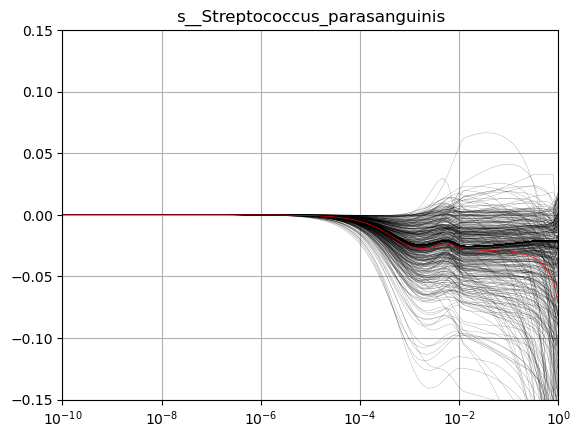

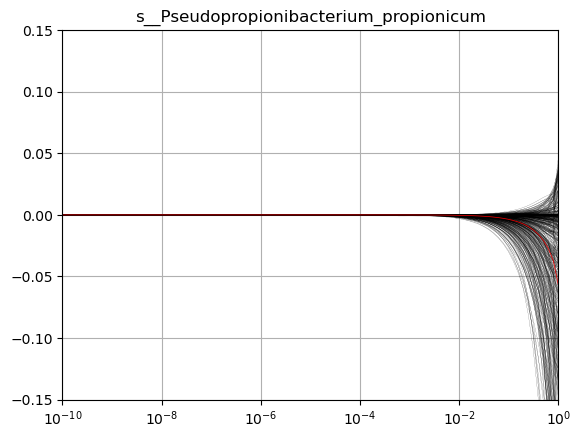

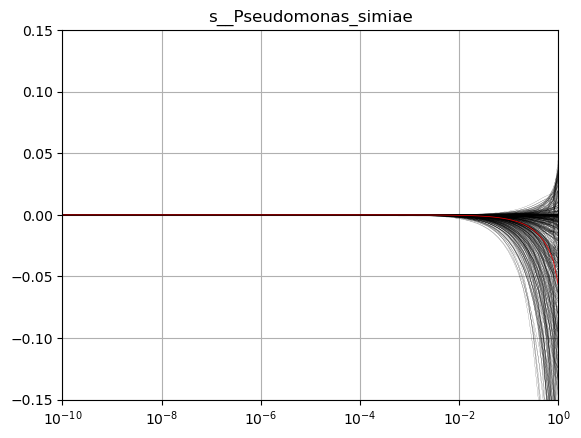

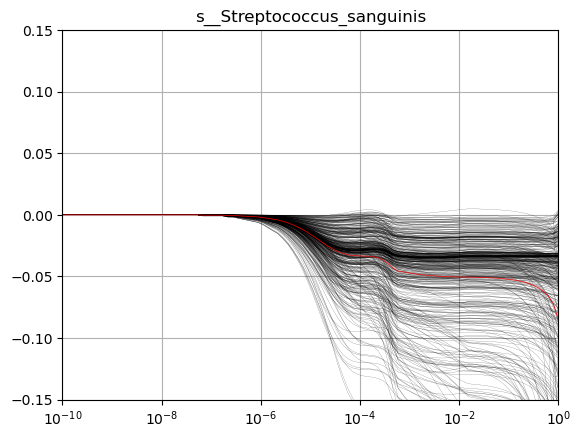

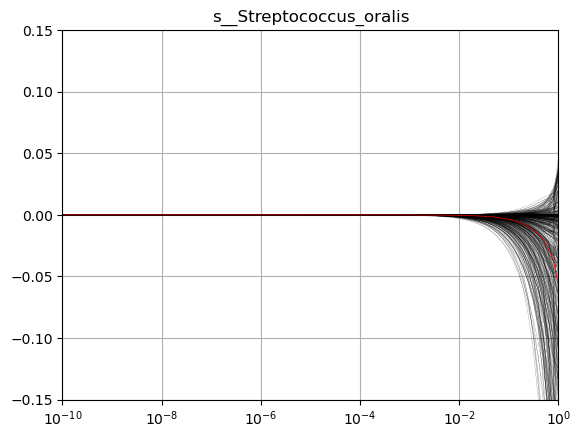

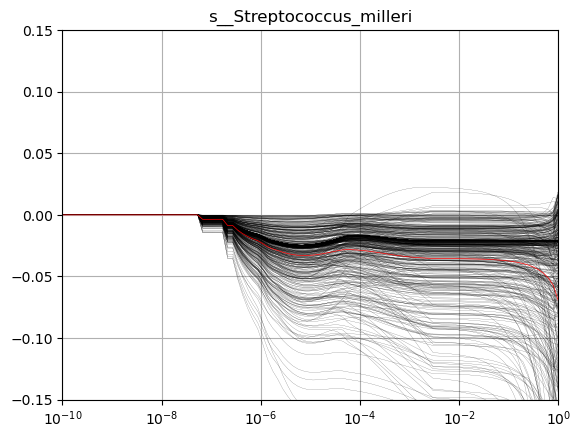

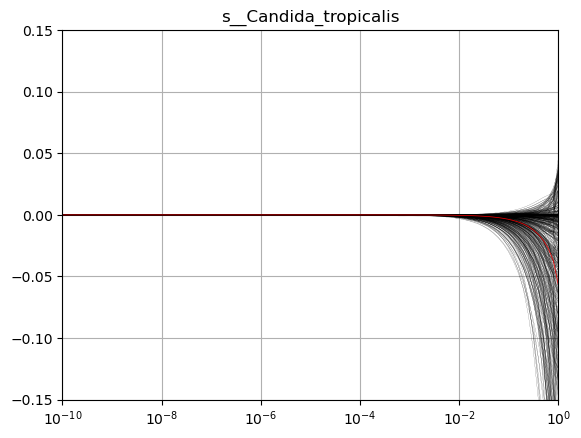

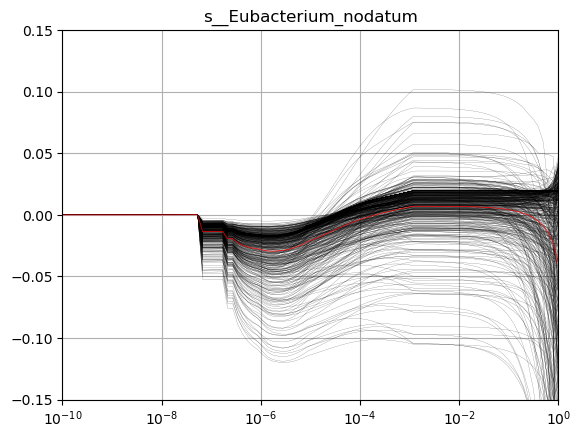

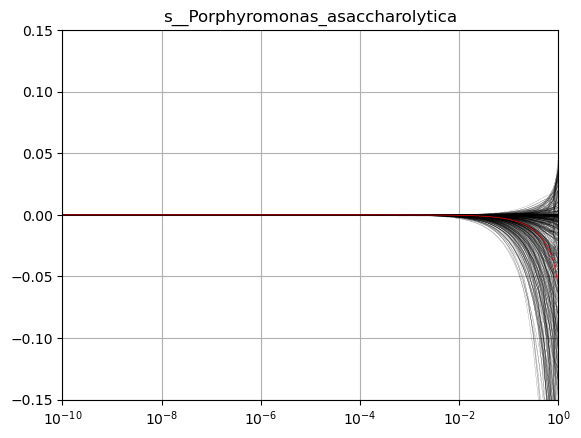

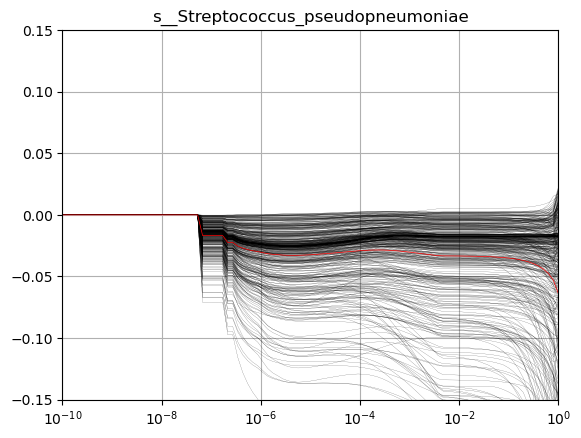

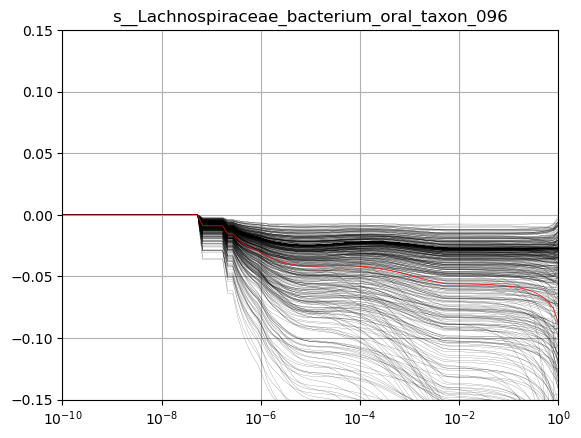

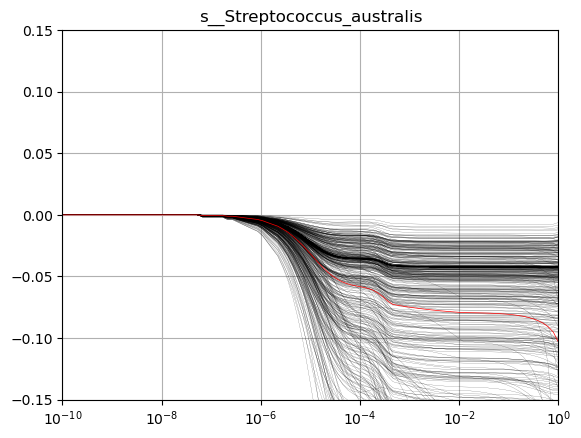

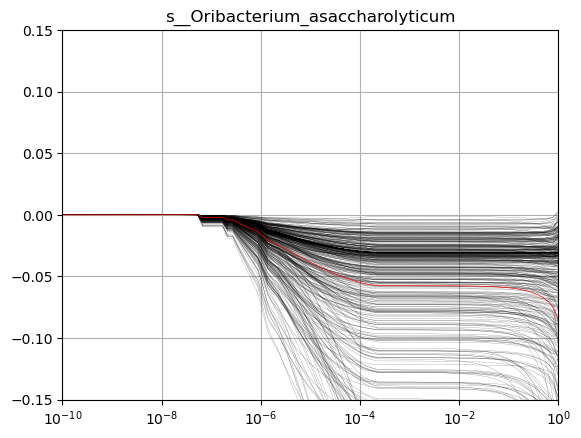

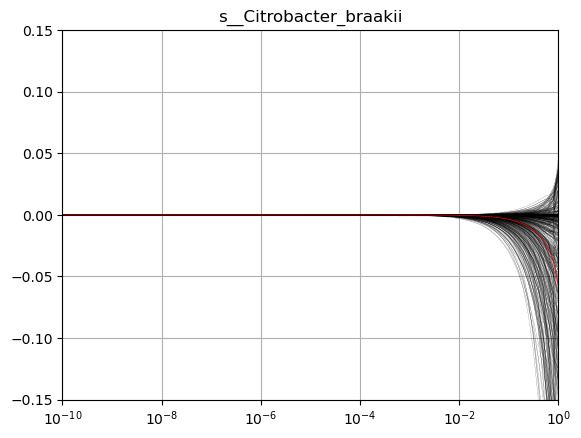

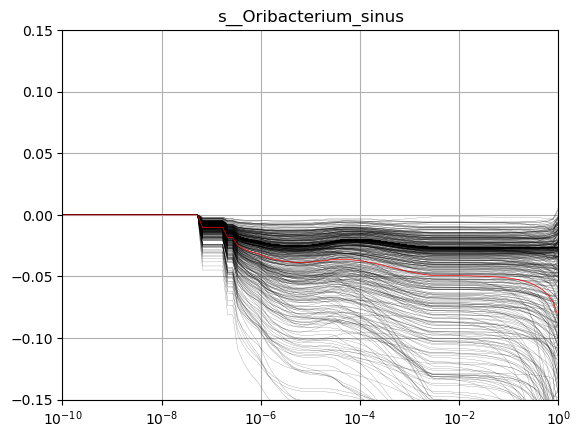

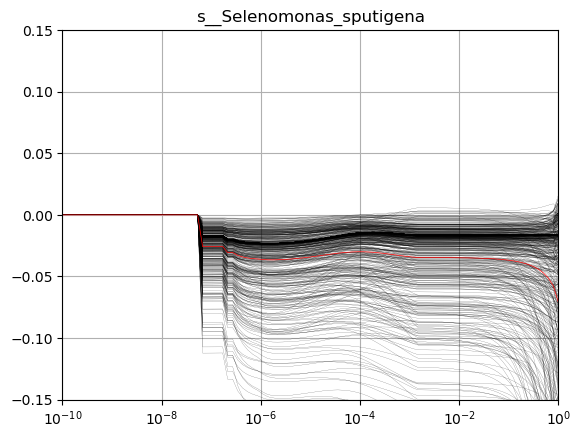

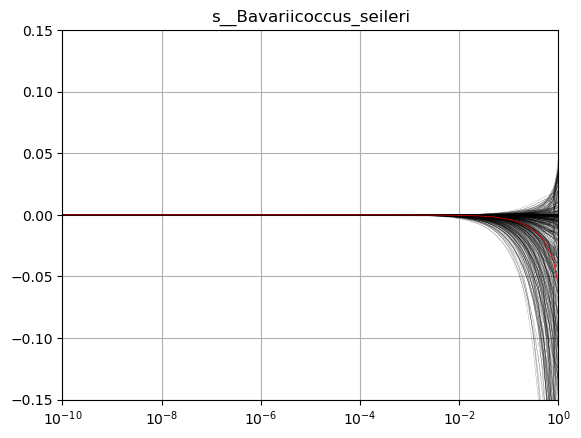

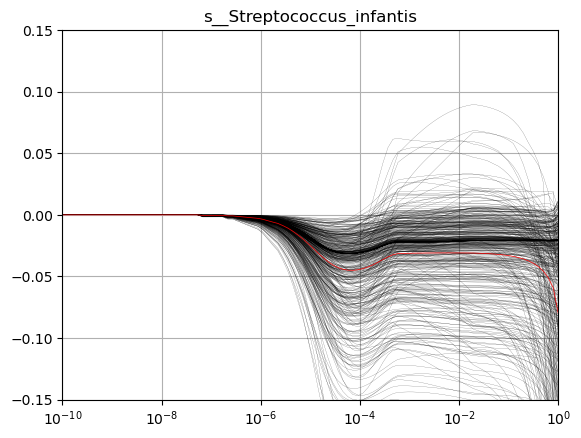

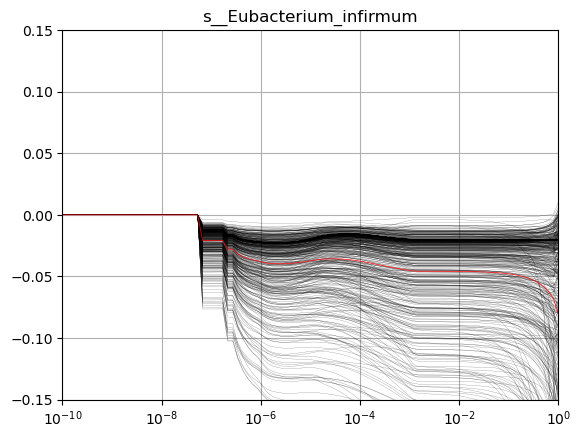

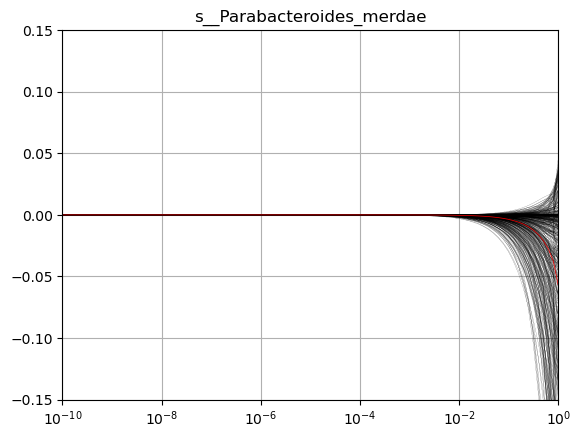

In [65]:

#print(np.where(["Prevotella_inter" in b for b in bacteria_names]))
#print(np.array(bacteria_names)[np.where(["Prevotella_inter" in b for b in bacteria_names])])

num = 100
features = best[:20]#[637, 1063, 921]#+list(best[:50])#[637, 1063]#best[50:100]#[921]
#features = [921,44,1240,1000,1031,257,637, 1063]
for f in features:
    fvalues = np.geomspace(np.min(all_data[(all_data[:,f]>0),f])+1e-10,np.max(all_data[:,f]),num=num)
    fvalues = np.geomspace(1e-10,1,num=num)
    #print(fvalues)
    #print(ice_curves.shape)
    ice_curves = np.load(f"results/ice/newmod_small_feature{f}.npy")
    for i in range(512):
        plt.plot(fvalues, ice_curves[:,i]-ice_curves[0,i], linewidth=0.1, c="black")
        #plt.plot(fvalues, ice_curves[:,i], linewidth=0.1, c="black")
    plt.plot(fvalues, np.mean(ice_curves-ice_curves[0,:], axis=1), linewidth=0.5, c="red")
    #plt.plot(fvalues, np.mean(ice_curves, axis=1), linewidth=0.5, c="red")
    plt.ylim(-0.15,0.15)
    plt.xlim(1e-10,1)
    plt.grid()
    plt.xscale("log")
    plt.title(bacteria_names[f])
    plt.show()

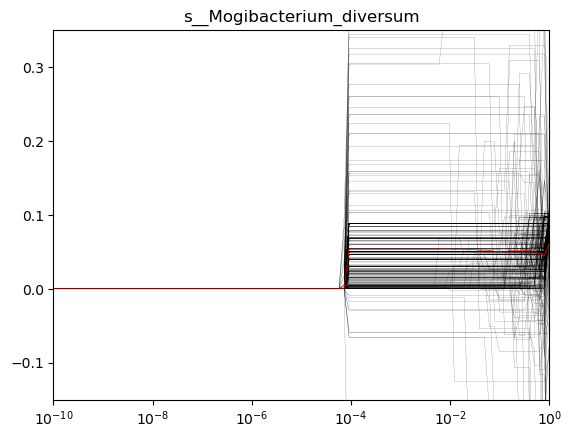

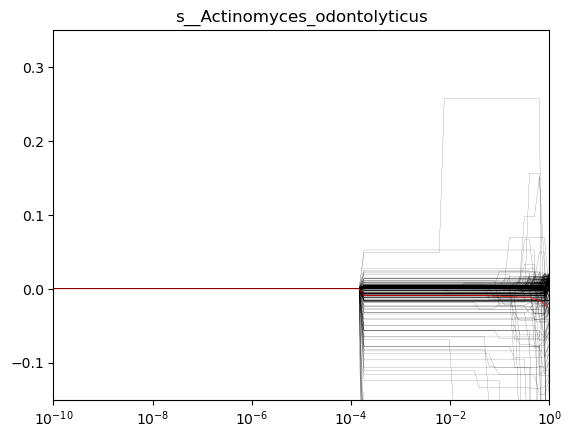

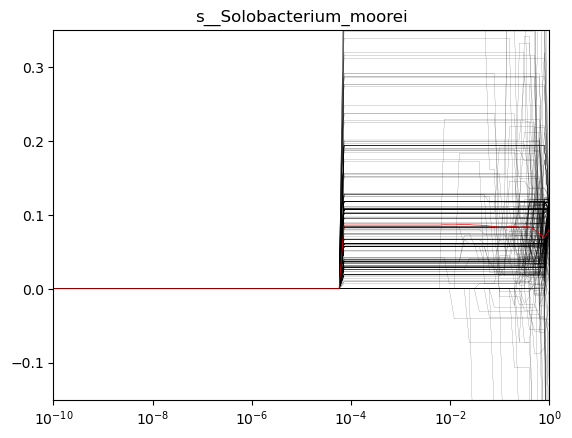

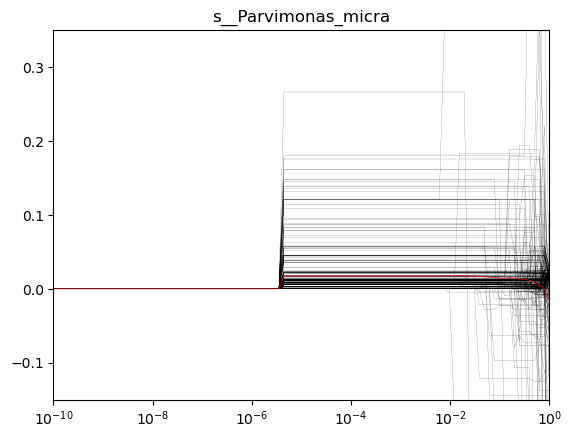

FileNotFoundError: [Errno 2] No such file or directory: 'results/ice/xgbfeature1031.npy'

In [59]:

#print(np.where(["Prevotella_inter" in b for b in bacteria_names]))
#print(np.array(bacteria_names)[np.where(["Prevotella_inter" in b for b in bacteria_names])])

num = 100
#features = [637, 1063, 921]#+list(best[:50])#[637, 1063]#best[50:100]#[921]
features = best[:20]
features = [921,44,1240,1000,1031,257,637, 1063]
for f in features:
    fvalues = np.geomspace(np.min(all_data[(all_data[:,f]>0),f])+1e-10,np.max(all_data[:,f]),num=num)
    fvalues = np.geomspace(1e-10,1,num=num)
    #print(fvalues)
    #print(ice_curves.shape)
    ice_curves = np.load(f"results/ice/xgbfeature{f}.npy")
    for i in range(512):
        plt.plot(fvalues, ice_curves[:,i]-ice_curves[0,i], linewidth=0.1, c="black")
    plt.plot(fvalues, np.mean(ice_curves-ice_curves[0,:], axis=1), linewidth=0.5, c="red")
    plt.ylim(-0.15,0.35)
    plt.xlim(1e-10,1)
    plt.xscale("log")
    plt.title(bacteria_names[f])
    plt.show()

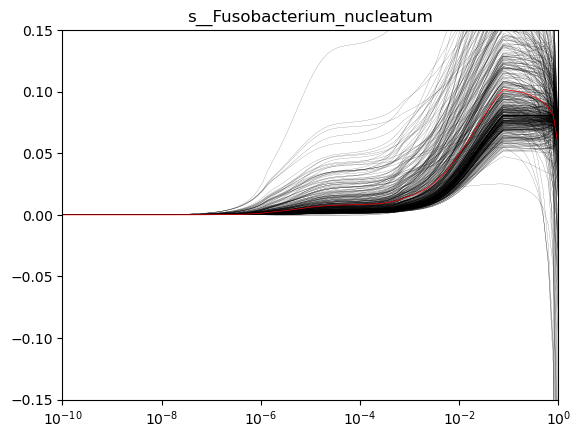

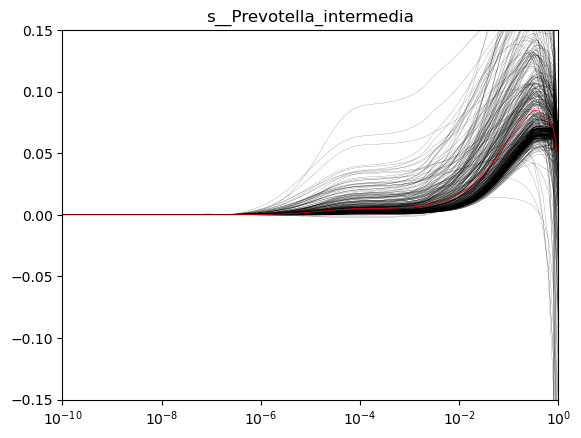

In [51]:

#print(np.where(["Prevotella_inter" in b for b in bacteria_names]))
#print(np.array(bacteria_names)[np.where(["Prevotella_inter" in b for b in bacteria_names])])

num = 100
#features = [637, 1063, 921]#+list(best[:50])#[637, 1063]#best[50:100]#[921]
for f in features:
    fvalues = np.geomspace(np.min(all_data[(all_data[:,f]>0),f])+1e-10,np.max(all_data[:,f]),num=num)
    fvalues = np.geomspace(1e-10,1,num=num)
    #print(fvalues)
    #print(ice_curves.shape)
    ice_curves = np.load(f"results/ice/pfnfeature{f}.npy")
    for i in range(512):
        plt.plot(fvalues, ice_curves[:,i]-ice_curves[0,i], linewidth=0.1, c="black")
    plt.plot(fvalues, np.mean(ice_curves-ice_curves[0,:], axis=1), linewidth=0.5, c="red")
    plt.ylim(-0.15,0.15)
    plt.xlim(1e-10,1)
    plt.xscale("log")
    plt.title(bacteria_names[f])
    plt.show()

### Data valuation - Leave-one-out (LOO)

In [ ]:
save = True
no_pre_process = False
multi_decoder = "permutation"
N_ens = 3
seed = 42
overwrite = True
metrics = ["roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_mlp_var_balance_05weight_anova"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
model = MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process)

reducer = AnovaSelect()

n_folds = 7
s = all_data.shape[0]
data_c0 = all_data[labels==0]
data_c1 = all_data[labels==1]
c0_frac = data_c0.shape[0]/all_data.shape[0]
c1_frac = 1-c0_frac#data_c1.shape[0]/all_data.shape[0]
X_folds, y_folds = [], []
fs = int(s/n_folds)
for nr in range(n_folds-1):
    fold = np.concatenate((data_c0[int(fs*c0_frac)*nr:int(fs*c0_frac)*(nr+1),:],
                          data_c1[int(fs*c1_frac)*nr:int(fs*c1_frac)*(nr+1),:]),axis=0)
    new_labels = np.concatenate((np.zeros(int(fs*c0_frac)), np.ones(int(fs*c1_frac))))
    X_folds.append(fold)
    y_folds.append(new_labels)
fold = np.concatenate((data_c0[int(fs*c0_frac)*(n_folds-1):],
                      data_c1[int(fs*c1_frac)*(n_folds-1):]),axis=0)
new_labels = np.concatenate((np.zeros(data_c0.shape[0]-int(fs*c0_frac)*(n_folds-1)), np.ones(data_c1.shape[0]-int(fs*c1_frac)*(n_folds-1))))
X_folds.append(fold)
y_folds.append(new_labels)
dvs = []
for run in range(n_folds):
    print(run)
    X_folds = X_folds[run+1:] + X_folds[:run+1]
    y_folds = y_folds[run+1:] + y_folds[:run+1]
    X_test, y_test = np.concatenate(tuple(X_folds[:-1])), np.concatenate(tuple(y_folds[:-1]))
    X_train, y_train = X_folds[-1], y_folds[-1]
    X_train, X_test = remove_same_features_traintest(X_train, X_test)
    X_train, y_train = unison_shuffled_copies(X_train, y_train)
    X_test, y_test = unison_shuffled_copies(X_test, y_test)
    reducer.fit(X_train, y_train)
    X_train = reducer.transform(X_train)
    X_test = reducer.transform(X_test)
    X_test, y_test = X_test[:512], y_test[:512]
    # with datapoint
    model.fit(X_train, y_train, overwrite_warning=True)
    probs = model.predict_proba(X_test)
    #if model_clean.__class__.__name__=="MedPFNClassifier":
    probs = (probs[:,1]-probs[:,0]+1)*0.5
    m = "roc_auc"
    result = sklearn.metrics.get_scorer(m)._score_func(y_test, probs)
    #print(result)
    for x in range(X_train.shape[0]):
        #without datapoint
        X_train_wo = np.delete(X_train, x, axis=0)
        y_train_wo = np.delete(y_train, x, axis=0)
        model.fit(X_train_wo, y_train_wo, overwrite_warning=True)
        probs = model.predict_proba(X_test)
        #if model_clean.__class__.__name__=="MedPFNClassifier":
        probs = (probs[:,1]-probs[:,0]+1)*0.5
        m = "roc_auc"
        result_wo = sklearn.metrics.get_scorer(m)._score_func(y_test, probs)
    dvs.append(result-result_wo)

0
1
2
